##  <span style='color:green '>Evaluate Models Rookies Non-QB Skills</span>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')
import nfl_data_py as nfl
max_col = pd.get_option("display.max_columns")

###  <span style='color:green '> Set up variables to be used in Fit Determination Function</span>

In [2]:
index = []
scores = {'Train Score': [], "Test Score": [], 'Test Train Difference': [], 'Scaler': []}
scalers = ["none", StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()]
models = [LinearRegression(),
          LogisticRegression(),
#           KNeighborsRegressor(),
          RandomForestRegressor(),
          RandomForestClassifier(),
          ExtraTreesRegressor(),
          ExtraTreesClassifier(),
          AdaBoostRegressor(),
          AdaBoostClassifier()]

###  <span style='color:green '>Define Function to Test Models and Scalers</span>

In [3]:
def test_model(data):
    for scaler in scalers:
        global index
        global scores
        if scaler != "none":
            scaler.fit(X_train)
            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test
        data = X_train_scaled, X_test_scaled, y_train, y_test
        for model in models:
            reg = model.fit(X_train_scaled, y_train)
            y_pred = reg.predict(X_test_scaled)            
            scores["Train Score"].append(reg.score(X_train_scaled, y_train))
            scores["Test Score"].append(reg.score(X_test_scaled, y_test))
            scores["Test Train Difference"].append((reg.score(X_train_scaled, y_train)-(reg.score(X_test_scaled, y_test))))
            scores["Scaler"].append(scaler)
            index += [type(reg).__name__]

###  <span style='color:green '>Get data and evaluate readiness for model</span>

 <span style='color:green '>* Find features and target   
     * Test for imbalance </span>

In [4]:
nfl.see_pbp_cols() # Displays available columns
pbp2021 = nfl.import_pbp_data(years=[2021], downcast=True, cache=False, alt_path=None)

# load additional team data 
pbpclean = pbp2021
teams = nfl.import_team_desc()
players = nfl.import_rosters([2021])
player_seasons = nfl.import_seasonal_data([2021])
player_seasons.head(5)

adp = pd.read_csv('Resources/Rookies_QB.csv') 

adp['2019 FantasyPoints'] = 0
adp['2020 FantasyPoints'] = 0
adp['Average Total Production'] = 0
adp['Production21'] = 0
adp = adp.rename(columns={'2021 Fantasy Points':'2021 FantasyPoints'})

2021 done.
Downcasting floats.


In [5]:
# Preserve label information for Output file 
adp_scope = adp[['Player',
                 '2021 FantasyPoints',
                 '2021 Tm',
                 'Pos',
                 'AVG'
                ]].copy()

adp_scope['2019 FantasyPoints'] = 0
adp_scope['2020 FantasyPoints'] = 0
adp_scope['Average Total Production'] = 0
adp_scope['Production21'] = 0
adp_scope.head(5)

,Player,2021 FantasyPoints,2021 Tm,Pos,AVG,2019 FantasyPoints,2020 FantasyPoints,Average Total Production,Production21
0,Kenny Pickett,102.4,PIT,QB,265.5,0,0,0,0
1,Malik Willis,12.1,TEN,QB,316.0,0,0,0,0
2,Desmond Ridder,80.5,ATL,QB,287.0,0,0,0,0
3,Sam Howell,8.1,WAS,QB,NaN,0,0,0,0


In [6]:
# Replace infinite updated data with 'drop'
# drop these rows from what will become our result set 
adp_scope.replace([np.inf, -np.inf], 'drop', inplace=True)
res = adp_scope[~adp_scope.eq('drop').any(1)]
adp_scope  = res
adp_scope.head(5)

,Player,2021 FantasyPoints,2021 Tm,Pos,AVG,2019 FantasyPoints,2020 FantasyPoints,Average Total Production,Production21
0,Kenny Pickett,102.4,PIT,QB,265.5,0,0,0,0
1,Malik Willis,12.1,TEN,QB,316.0,0,0,0,0
2,Desmond Ridder,80.5,ATL,QB,287.0,0,0,0,0
3,Sam Howell,8.1,WAS,QB,NaN,0,0,0,0


In [7]:
# Get the mean of the Average of the Average Draft Position 
meanJoeGreen = adp["AVG"].mean()
adp["AVG"] = adp["AVG"].fillna(meanJoeGreen)

In [8]:
# Invert ADP
adp['AvgInvert'] = (adp['AVG'].max() + 1) - adp['AVG']
# Give Production Scores and Most recent Fantasy Point equal Weight
adp['ProdWeighted'] = adp['2021 FantasyPoints']
# Factor in "human factor" of current ADP
adp['ProdWeightedSRA'] = (adp['ProdWeighted'] + adp['AvgInvert'])/2
# Correct any Nulls created by source data errors 
adp["ProdWeightedSRA"] = adp["ProdWeightedSRA"].fillna(114)
adp.head(5)

,Unnamed: 0,Player,2021 Tm,2021 RushingYds,Touchdowns21,2021 FantasyPoints,Pos,AVG,2019 FantasyPoints,2020 FantasyPoints,Average Total Production,Production21,AvgInvert,ProdWeighted,ProdWeightedSRA
0,19,Kenny Pickett,PIT,1559.0,9.2,102.4,QB,265.5,0,0,0,0,51.5,102.4,76.95
1,23,Malik Willis,TEN,188.7,1.0,12.1,QB,316.0,0,0,0,0,1.0,12.1,6.55
2,27,Desmond Ridder,ATL,1189.8,6.2,80.5,QB,287.0,0,0,0,0,30.0,80.5,55.25
3,40,Sam Howell,WAS,109.2,0.8,8.1,QB,289.5,0,0,0,0,27.5,8.1,17.80


In [9]:
adp_production = adp[['Player',
                     '2019 FantasyPoints',
                     '2020 FantasyPoints',
                     '2021 FantasyPoints',
                     'ProdWeighted',
                     '2021 Tm',
                     'Pos',
                     'AVG'
                    ]].copy()

In [10]:
# Verify that 2021 production has corrected values 
adp["Production21"].value_counts()

0    4
Name: Production21, dtype: int64

In [11]:
# Check for invalid data
count_nan = adp.isna().sum().sum()
count_nan

0

In [12]:
# Identify invalid data 
# These columns are drop from the ML Dataset 
# They are added back to the results set 
# they will still need to be corrected in the 
# previous step. 
missing_average = adp['AVG'].isna().sum()
missing_pos = adp['Pos'].isna().sum()
missing_team = adp['2021 Tm'].isna().sum()
print(f'Column AVG has {missing_average} null values')
print(f'Column POS has {missing_pos} null values')
print(f'Column Team has {missing_team} null values')

Column AVG has 0 null values
Column POS has 0 null values
Column Team has 0 null values


In [13]:
# Remove unnamed column, Player, Pos and 2021 Team
col = [0,1,2]
adp.drop(adp.columns[col],axis=1,inplace=True)

# For rookies only drop the 'Pos' column by name 
# Arrives in a different order
adp.drop('Pos', axis=1, inplace=True)
adp.head(5)

,2021 RushingYds,Touchdowns21,2021 FantasyPoints,AVG,2019 FantasyPoints,2020 FantasyPoints,Average Total Production,Production21,AvgInvert,ProdWeighted,ProdWeightedSRA
0,1559.0,9.2,102.4,265.5,0,0,0,0,51.5,102.4,76.95
1,188.7,1.0,12.1,316.0,0,0,0,0,1.0,12.1,6.55
2,1189.8,6.2,80.5,287.0,0,0,0,0,30.0,80.5,55.25
3,109.2,0.8,8.1,289.5,0,0,0,0,27.5,8.1,17.80


In [14]:
# Check for remaining nulls 
count_nan = adp.isna().sum().sum()
count_nan

0

In [15]:
# Look for non numerics 
adp.applymap(np.isreal)
invalidNumbers = adp[~adp.applymap(np.isreal).all(1)]
if len(invalidNumbers) > 0:
    print((f'There are {len(invalidNumbers)} rows with invaid numeric data'))

In [16]:
# This may not be required for rookie dataset
# Replace infinite updated data with nan
adp.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN that were just created by the infinity value replacements
adp.dropna(inplace=True)

In [17]:
# Set Target Variable 
Target = adp["ProdWeightedSRA"].values

In [18]:
print(len(Target))

4


###  <span style='color:green '>Apply Scaling for Initial Model Test </span>

In [19]:
# Standarize data with StandardScaler
# adps = StandardScaler().fit_transform(adp)
adps = MinMaxScaler().fit_transform(adp)
print(adps[0:1])

[[1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.]]


###  <span style='color:green '> PCA</span>
<span style='color:green '> Applying PCA to reduce dimensions while preserving 99% of the explained variance </span>

In [20]:
# Applying PCA to reduce dimensions while preserving 90% of the explained variance 
# Initialize PCA model by setting n-components to desired level
pca = PCA(n_components= .99)

# Fit our new Principal Component Analysis reduced Features to our Model
pfa = pca.fit_transform(adps)

# Transform PCA data to a DataFrame
pf = pd.DataFrame(data=pfa)
pf.head(2)

,0,1
0,1.404507,0.091488
1,-1.151513,-0.291794


###  <span style='color:green '>Create X and Y | Reshape the data</span>

In [21]:
# Create X (features) and y (target) sets
X = pf
y = Target

print("Shape: ", X.shape, y.shape)

Shape:  (4, 2) (4,)


###  <span style='color:green '>Split data into Training and Testing sets</span>

In [22]:
# Split the data into training and testing sets
data = X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

###  <span style='color:green '>Get to know our data</span>

Training Data Score: 1.0
Testing Data Score: nan


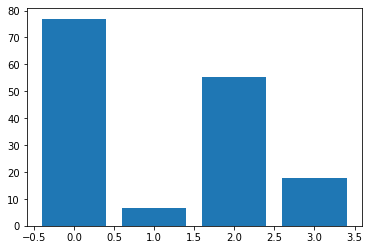

Wall time: 253 ms


In [23]:
%%time
# setting Random forest as sample to view data 
classifier = ExtraTreesRegressor()
# classifier = LinearRegression()
clf = classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

# Does not apply to linear Regression 
# features = clf.feature_importances_
# print(features)

# Plot for Linear Regression Model 
# Plots entire dataset not useful on large data 
plt.bar(x = range(len(X)), height=y)
plt.show()

In [24]:
y_predicted = clf.predict(X_test)
scores1 = clf.score(X_test, y_test)

print(y_predicted)
print(scores1)

[35.027]
nan


In [25]:
y_predicted = clf.predict(X)
print(y_predicted)

[76.95  35.027 55.25  17.8  ]


In [26]:
adp_scope['Prediction'] = y_predicted
adp_scope.rename(columns={"2021 Tm": "Team"})

,Player,2021 FantasyPoints,Team,Pos,AVG,2019 FantasyPoints,2020 FantasyPoints,Average Total Production,Production21,Prediction
0,Kenny Pickett,102.4,PIT,QB,265.5,0,0,0,0,76.950
1,Malik Willis,12.1,TEN,QB,316.0,0,0,0,0,35.027
2,Desmond Ridder,80.5,ATL,QB,287.0,0,0,0,0,55.250
3,Sam Howell,8.1,WAS,QB,NaN,0,0,0,0,17.800


In [27]:
adp_scope.sort_values('Prediction', ascending=False).head(50)

,Player,2021 FantasyPoints,2021 Tm,Pos,AVG,2019 FantasyPoints,2020 FantasyPoints,Average Total Production,Production21,Prediction
0,Kenny Pickett,102.4,PIT,QB,265.5,0,0,0,0,76.950
2,Desmond Ridder,80.5,ATL,QB,287.0,0,0,0,0,55.250
1,Malik Willis,12.1,TEN,QB,316.0,0,0,0,0,35.027
3,Sam Howell,8.1,WAS,QB,NaN,0,0,0,0,17.800


In [28]:
# save
joblib.dump(classifier, "Resources/draft_Rookie_QB.joblib")

# Temporary write file while we are working on data ***
adp_scope.dropna(subset=['AVG'])

adp_scope.to_csv('Resources/Draft_Rookie_QB.csv', index=False)

### <span style='color:green '>The section below is to evaluate new potential Models </span>

In [29]:
# Create X (features) and y (target) sets
X = pf

#convert y values to categorical values(for model selection matrix)
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)
y = y_transformed

# Split the data into training and testing sets
data = X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)
print(len(y))
print(len(X))

4
4


In [30]:
%%time
# call function test_model to test all models being considered
scores = {'Train Score': [], "Test Score": [], 'Test Train Difference': [], 'Scaler': []}
test_model(data)

Wall time: 3.07 s


In [31]:
# Print by Training Score
df_scores = pd.DataFrame(scores, index=index)
df_scores.sort_values('Train Score', ascending=False).head(25)

,Train Score,Test Score,Test Train Difference,Scaler
LinearRegression,1.0,NaN,NaN,none
ExtraTreesClassifier,1.0,0.0,1.0,MaxAbsScaler()
ExtraTreesClassifier,1.0,0.0,1.0,MinMaxScaler()
AdaBoostRegressor,1.0,NaN,NaN,MinMaxScaler()
AdaBoostClassifier,1.0,0.0,1.0,MinMaxScaler()
LinearRegression,1.0,NaN,NaN,MaxAbsScaler()
LogisticRegression,1.0,0.0,1.0,MaxAbsScaler()
RandomForestClassifier,1.0,0.0,1.0,MaxAbsScaler()
ExtraTreesRegressor,1.0,NaN,NaN,MaxAbsScaler()
AdaBoostRegressor,1.0,NaN,NaN,MaxAbsScaler()


In [32]:
# Print by Testing Score
df_scores.sort_values('Test Score', ascending=False).head(25)

,Train Score,Test Score,Test Train Difference,Scaler
LogisticRegression,1.00000,0.0,1.0,none
RandomForestClassifier,1.00000,0.0,1.0,none
ExtraTreesClassifier,1.00000,0.0,1.0,RobustScaler()
RandomForestClassifier,1.00000,0.0,1.0,RobustScaler()
LogisticRegression,1.00000,0.0,1.0,RobustScaler()
AdaBoostClassifier,1.00000,0.0,1.0,MaxAbsScaler()
ExtraTreesClassifier,1.00000,0.0,1.0,MaxAbsScaler()
RandomForestClassifier,1.00000,0.0,1.0,MaxAbsScaler()
LogisticRegression,1.00000,0.0,1.0,MaxAbsScaler()
AdaBoostClassifier,1.00000,0.0,1.0,MinMaxScaler()


In [33]:
# Print by Testing Score
df_scores['Test Train Magnitude'] = abs(df_scores['Test Train Difference'])
df_scores.sort_values('Test Train Magnitude').head(25)

,Train Score,Test Score,Test Train Difference,Scaler,Test Train Magnitude
LogisticRegression,1.00000,0.0,1.0,none,1.0
RandomForestClassifier,1.00000,0.0,1.0,RobustScaler(),1.0
LogisticRegression,1.00000,0.0,1.0,RobustScaler(),1.0
AdaBoostClassifier,1.00000,0.0,1.0,MaxAbsScaler(),1.0
ExtraTreesClassifier,1.00000,0.0,1.0,MaxAbsScaler(),1.0
RandomForestClassifier,1.00000,0.0,1.0,MaxAbsScaler(),1.0
LogisticRegression,1.00000,0.0,1.0,MaxAbsScaler(),1.0
AdaBoostClassifier,1.00000,0.0,1.0,MinMaxScaler(),1.0
ExtraTreesClassifier,1.00000,0.0,1.0,MinMaxScaler(),1.0
RandomForestClassifier,1.00000,0.0,1.0,MinMaxScaler(),1.0


For the rookie model we had to look a little deeper into our training scores, due to the limited dataset models naturally over train and testing rates fall dramatically.

Despite training and testing outcome(s) using the same model as non QB skill positions gives us expected results for qb as a results all rookies will be run against the rookie model. 